# KNN

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unittest as ut
import math
from scipy import stats

## Data Loading

In [2]:
wine_train = pd.read_csv("data/part1/wine-training", delimiter=" ")
wine_test = pd.read_csv("data/part1/wine-test", delimiter=" ")

# check it's loaded in correctly
display(wine_train.head())
display(wine_test.head())

,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted_wines,Proline,Class
0,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,1
1,12.25,1.73,2.12,19.0,80.0,1.65,2.03,0.37,1.63,3.40,1.00,3.17,510.0,2
2,11.82,1.47,1.99,20.8,86.0,1.98,1.60,0.30,1.53,1.95,0.95,3.33,495.0,2
3,13.05,2.05,3.22,25.0,124.0,2.63,2.68,0.47,1.92,3.58,1.13,3.20,830.0,1
4,13.29,1.97,2.68,16.8,102.0,3.00,3.23,0.31,1.66,6.00,1.07,2.84,1270.0,1


,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted_wines,Proline,Class
0,12.70,3.55,2.36,21.5,106.0,1.70,1.20,0.17,0.84,5.00,0.78,1.29,600.0,3
1,12.20,3.03,2.32,19.0,96.0,1.25,0.49,0.40,0.73,5.50,0.66,1.83,510.0,3
2,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.20,0.61,1.60,560.0,3
3,13.05,1.65,2.55,18.0,98.0,2.45,2.43,0.29,1.44,4.25,1.12,2.51,1105.0,1
4,14.19,1.59,2.48,16.5,108.0,3.30,3.93,0.32,1.86,8.70,1.23,2.82,1680.0,1


## Data Exploration 

Lets try to understand our data first.

No missing values.

In [3]:
# check for missing values
display(np.where(pd.isnull(wine_train)))
display(np.where(pd.isnull(wine_test)))
display(np.where(pd.isna(wine_train)))
display(np.where(pd.isna(wine_test)))

(array([], dtype=int64), array([], dtype=int64))

(array([], dtype=int64), array([], dtype=int64))

(array([], dtype=int64), array([], dtype=int64))

(array([], dtype=int64), array([], dtype=int64))

Data Questions:
* I'm unsure what 'Class' represents here.
* We have 14 features, I thought we only had 13?

In [4]:
# check data types
print(wine_train.dtypes)
print(wine_train.shape)

Alcohol                         float64
Malic_acid                      float64
Ash                             float64
Alcalinity_of_ash               float64
Magnesium                       float64
Total_phenols                   float64
Flavanoids                      float64
Nonflavanoid_phenols            float64
Proanthocyanins                 float64
Color_intensity                 float64
Hue                             float64
OD280/OD315_of_diluted_wines    float64
Proline                         float64
Class                             int64
dtype: object
(89, 14)


After checking the data further, I have found
* 'Class' is which type of wine it is, which we can treat like a nominal datatype.
* 'Class' is the extra attribute.

There are only 3 classes in our dataset

In [5]:
wine_train['Class'].unique()

array([1, 2, 3])

## Implement KNN

The heart of how KNN works by checking the closest k nodes with each feature.
* Use Euclidean distance to calculate the space between multiple dimensions using the following algorithm taken from https://en.wikipedia.org/wiki/Euclidean_distance    
* I've added normalization to this formula.
$$ d(p,q) = \sqrt{\frac{(p_1 - q_1)^2}{(max(p) - min(p))^2} + \frac{(p_2 - q_2)^2}{(max(p) - min(p))^2} + ... + \frac{(p_n - q_n)^2}{(max(p) - min(p))^2}} $$

In [6]:
class KNN:
    def __init__(self, n_neighbours):
        import numpy as np
        from scipy import stats
        self.n_neighbours = n_neighbours

    def train(self, X: pd.DataFrame, y: pd.Series):
        self.X = X
        self.y = y
        self.max_min = self.__max_min(X)
        return self
    
    def test(self, X_test: pd.DataFrame):
        """Returns the classified nodes in a list."""
        self.classified = [self.__classify(X_test.iloc[row]) for row in range(len(X_test))]
        return self.classified
    
    def __max_min(self, p: pd.DataFrame) -> list[float]:
        """Calculates the difference between the max and min of each predictor variable."""
        self.max_min: list[float] = [(max(p[x]) - min(p[x])) ** 2 for x in p]
        return self.max_min   
    
    def __euclidean(self, ob1: pd.Series, ob2: pd.Series) -> list[float]:
        """Calculates the normalized euclidean distance between all of the features of two observations."""
        return [(ob1[i] - ob2[i])**2 for i in range(len(ob1))]  # type: ignore
    
    def __normalized_euclidean(self, ob1: pd.Series, ob2: pd.Series):
        """Uses the __euclidean function and __max_min function to calculate the normalized euclidean distance between two observations"""
        return np.sqrt(sum(pd.Series(self.__euclidean(ob1, ob2)) / pd.Series(self.max_min)))
    
    def __classify(self, X_test: pd.Series) -> int:
        """Calculate the normalized euclidean distance between each row in X_train and a single X_test row, then sort it with the n closest neighbours and classify."""
        norm_dist = [self.__normalized_euclidean(self.X.iloc[i], X_test) for i in range(len(self.X))]
        sorted_norm_dist = np.sort(norm_dist)[:self.n_neighbours]
        # find where the min k normalized distances are
        locs = [np.where(norm_dist == i) for i in sorted_norm_dist]
        # use these locations to find the corresponding class
        classes = [self.y[i[0][0]] for i in locs]
        # return the majority class
        return stats.mode(classes, keepdims = False)[0]
    
    def accuracy(self, y_test):
        """heck if classified nodes are correct"""
        return np.mean(self.classified == y_test)
    
    def confusion(self, y_test):
        width = len(y_test.unique())
        matrix = np.zeros((width, width))  # row, col - i = true, j = pred
        for i in range(len(self.classified)):
            matrix[y_test[i]-1][self.classified[i]-1] = matrix[y_test[i]-1][self.classified[i]-1] + 1
        self.confusion = matrix # type: ignore
        return self.confusion

## Evaluation
We get an accuracy of 94.38% (2dp) and 95.51% from our KNN model with 1 neighbour and with 3 neighbours respectively.
From our confusion matrix, we can see:
* All of the 2nd class was correctly identified. 
* Our model incorrectly interpreted 2 data points from class 1 as class 2.
* Incorrectly interpreted 3 data points from class 3 as class 2.

There appears to be a small amount of bias to class 2.

Our line plot shows us that the optimal values of K between 1 to 9 inclusive are 3, 7, 8 and 9 with the highest accuracy.

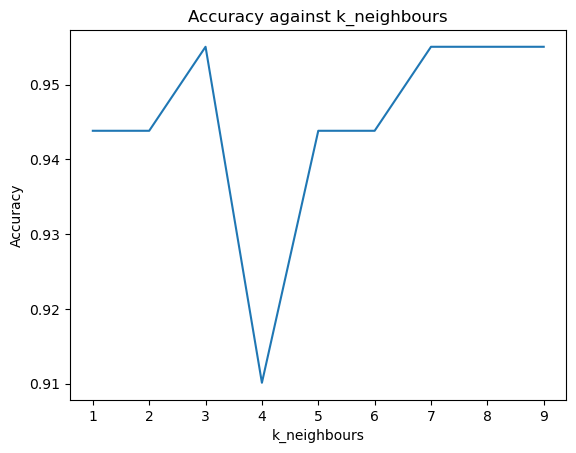

In [7]:
X_train = wine_train.drop("Class", axis = 1)
y_train = wine_train["Class"]
X_test  = wine_test.drop("Class", axis = 1)
y_test  = wine_test["Class"]    

accuracy = []
n = 10
for i in range(1, n):
    myKNN = KNN(i)
    pred_X = myKNN.train(X_train, y_train).test(X_test)
    accuracy.append(np.mean(pred_X == y_test))
plt.plot(range(1, n), accuracy)
plt.title("Accuracy against k_neighbours")
plt.ylabel("Accuracy")
plt.xlabel("k_neighbours")
plt.show()

In [8]:
myKNN = KNN(1)
pred_y = myKNN.train(X_train, y_train).test(X_test)
print(myKNN.accuracy(y_test))
print(myKNN.confusion(y_test))
print(pred_y)

0.9438202247191011
[[30.  0.  0.]
 [ 3. 30.  2.]
 [ 0.  0. 24.]]
[3, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 3, 3, 3, 1, 2, 3, 3, 1, 1, 3, 2, 2, 3, 2, 3, 2, 3, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 3, 1, 2, 1, 3, 2, 2, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 2, 3, 2, 3, 3, 1, 1, 2, 1, 3, 2, 2, 1, 1, 1, 3, 1, 1, 2, 2, 3, 1, 2, 1, 1, 2, 1]


In [9]:
myKNN = KNN(3)
pred_y = myKNN.train(X_train, y_train).test(X_test)
print(myKNN.accuracy(y_test))
print(myKNN.confusion(y_test))
print(pred_y)

0.9550561797752809
[[30.  0.  0.]
 [ 1. 31.  3.]
 [ 0.  0. 24.]]
[3, 3, 3, 1, 1, 1, 2, 2, 1, 2, 3, 3, 3, 3, 1, 2, 3, 3, 1, 1, 3, 2, 2, 3, 2, 3, 2, 3, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 3, 1, 2, 1, 3, 2, 2, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 2, 3, 2, 3, 3, 1, 1, 2, 2, 3, 2, 2, 1, 1, 1, 3, 1, 1, 2, 2, 3, 1, 2, 1, 1, 2, 1]
